In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import re

In [ ]:
# split up 6.25 million games into 5 sets of 1.25 million games each (4Gb -> ~700Mb)
input_file = r"C:\Projekte\chess_elo_prediction\data\chess_games.csv"
output_dir = "data/split_data"
os.makedirs(output_dir, exist_ok=True)
cols = ["WhiteElo", "BlackElo", "AN"]
chunksize = 100000
target = 1250000
current_file = 1
current_count = 0

for chunk in pd.read_csv(input_file, usecols=cols, chunksize=chunksize):
    start_idx = 0
    while start_idx < len(chunk) and current_file <= 5:
        remaining = target - current_count
        subset = chunk.iloc[start_idx:start_idx + remaining]
        out_path = os.path.join(output_dir, f"set_{current_file}.csv")
        subset.to_csv(out_path, mode='a', header=(current_count == 0), index=False)
        n_written = len(subset)
        current_count += n_written
        start_idx += n_written
        if current_count >= target:
            current_file += 1
            current_count = 0
            if current_file > 5:
                break

In [ ]:
# idea: only keep games that ended in a draw and use a bot that will always try to draw for the demonstration (trained on this exact dataset)

df_full = pd.DataFrame(columns=["WhiteElo", "BlackElo", "AN"])
unique_moves = set()
max_rating = 0

def is_valid_row(token_list):
    for token in token_list:
        if token in {"{", "}"} or "[%eval" in token:
            return False
    return True

for i in range(1, 6):
    input_file = fr"C:\Projekte\chess_elo_prediction\data\split_data\set_{i}.csv"
    df_tmp = pd.read_csv(input_file, usecols=["WhiteElo", "BlackElo", "AN"])
    max_rating_tmp = max(df_tmp["WhiteElo"].max(), df_tmp["BlackElo"].max())

    # we accept that we wont capture all tokens (by this exec order) -> on set_1 ~11K unique_moves, on the 220K draws -> 7384 unique moves TODO!!!
    df_tmp["Result"] = df_tmp["AN"].apply(lambda x: "Draw" if "1/2-1/2" in x else "NA")
    df_tmp = df_tmp[df_tmp["Result"] == "Draw"]

    df_tmp["AN"] = df_tmp["AN"].apply(lambda x: re.sub(r"\d+\.", "", x))
    df_tmp["AN"] = df_tmp["AN"].str.replace("1/2-1/2", "", regex=False)
    df_tmp["moves_tokenized"] = df_tmp["AN"].apply(lambda x: x.split())
    df_tmp = df_tmp[df_tmp["moves_tokenized"].apply(is_valid_row)]

    df_tmp = df_tmp[df_tmp["moves_tokenized"].apply(len) >= 10]
    
    df_tmp["moves_tokenized"] = df_tmp["moves_tokenized"].apply(lambda x: ["<EOS>"] + x + ["<EOS>"])

    for token_list in df_tmp["moves_tokenized"]:
        unique_moves.update(token_list)
    
    df_full = pd.concat([df_full, df_tmp], ignore_index=True)
    max_rating = max(max_rating, max_rating_tmp)

unique_moves = sorted(unique_moves)
move_to_idx = {move: i + 1 for i, move in enumerate(unique_moves)}
df_full["black_rating_scaled"] = df_full["BlackElo"] / max_rating
df_full["white_rating_scaled"] = df_full["WhiteElo"] / max_rating
df_full["moves_encoded"] = df_full["moves_tokenized"].apply(lambda row: [move_to_idx[move] for move in row])

print("df_full", len(df_full))
print(df_full["Result"].value_counts())

moves_df = pd.DataFrame({"move": unique_moves, "token_number": range(1, len(unique_moves) + 1)})
moves_df.to_csv(r"C:\Projekte\chess_elo_prediction\data\unique_moves.csv", index=False)

df_full.drop(columns=["WhiteElo", "BlackElo", "AN", "Result", "moves_tokenized"], inplace=True)

print(df_full.info())
print(df_full.head())

print("unique_moves", len(unique_moves))
print("max_rating", max_rating)

output_file = r"C:\Projekte\chess_elo_prediction\data\final_normalized.csv"
df_full.to_csv(output_file, index=False)

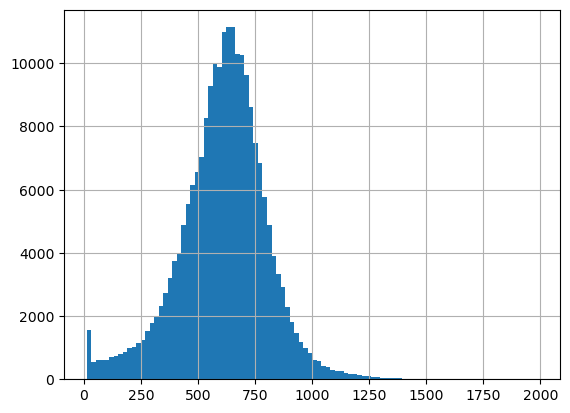

In [5]:
df = pd.read_csv("data/final_normalized.csv")
df["moves_encoded_length"] = df["moves_encoded"].apply(len)
df["moves_encoded_length"].hist(bins=100)
plt.show()

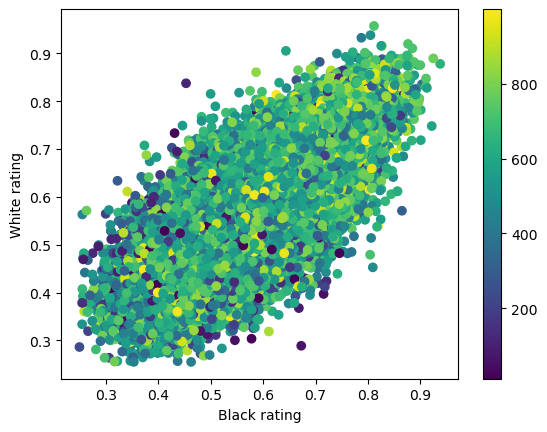

In [7]:
df = pd.read_csv("data/final_normalized.csv")
df = df[df["moves_encoded"].apply(len) < 1000]
plt.scatter(df["black_rating_scaled"], df["white_rating_scaled"], c=df["moves_encoded"].apply(len))
plt.xlabel("Black rating")
plt.ylabel("White rating")
plt.colorbar()
plt.show()

In [ ]:
# idea only use games (with whatever outcome) where the black rating is within 10% of the average rating
# OR only use games where the black rating is within 10% of the white rating

# TODO remove short games (e.g. less than 10 moves)